In [64]:
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

from tsa import config

In [65]:
ridge_a = joblib.load(config.MODELS_DIR / "ridge_macro_forecast_results.joblib")
ridge_b = joblib.load(config.MODELS_DIR / "ridge_local_forecast_results.joblib")

var = joblib.load(config.MODELS_DIR / "var_forecast_results.joblib")

## Model Performance Summary

In [66]:
results_df = pd.DataFrame(
    {
        "Model A (Ridge Macro)": {
            "MSE": ridge_a["mse"],
            "RMSE": ridge_a["rmse"],
        },
        "Model B (Ridge Local)": {
            "MSE": ridge_b["mse"],
            "RMSE": ridge_b["rmse"],
        },
        "Model C (VAR)": {
            "MSE": var["mse"],
            "RMSE": var["rmse"],
        },
    }
).T

print(results_df.round(4))

                          MSE    RMSE
Model A (Ridge Macro)  1.4638  1.2099
Model B (Ridge Local)  1.3152  1.1468
Model C (VAR)          3.1647  1.7790


## Diebold-Mariano Tests

In [67]:
def diebold_mariano_test(actual, pred1, pred2, h=1, one_sided=False):
    e1 = actual - pred1
    e2 = actual - pred2
    d = e1**2 - e2**2  # d positive means e1 is worse (Model 2 wins)

    d_mean = np.mean(d)
    n = len(d)
    gamma_0 = np.var(d, ddof=1)

    if h > 1:
        for k in range(1, h):
            gamma_k = np.sum((d[k:] - d_mean) * (d[:-k] - d_mean)) / (n - 1)
            gamma_0 += 2 * gamma_k

    dm_stat = d_mean / np.sqrt(gamma_0 / n)

    if one_sided:
        p_value = 1 - stats.norm.cdf(dm_stat)  # H1: pred2 better
    else:
        p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))  # Two-sided

    return dm_stat, p_value

### Two-Sided Tests (All Pairwise Comparisons)

In [68]:
comparisons = [
    ("Ridge Macro (A)", "Ridge Local (B)", ridge_a, ridge_b),
    ("Ridge Macro (A)", "VAR (C)", ridge_a, var),
    ("Ridge Local (B)", "VAR (C)", ridge_b, var),
]

for name1, name2, m1, m2 in comparisons:
    dm_stat, p_val = diebold_mariano_test(
        m1["actuals"], m1["predictions"], m2["predictions"]
    )

    print(f"\n{name1} vs {name2}:")
    print(f"    P-value:      {p_val:.4f}")

    if p_val < 0.05:
        # DM > 0 implies d > 0 implies e1 > e2 implies Model 2 is better
        # DM < 0 implies d < 0 implies e1 < e2 implies Model 1 is better
        winner = name2 if dm_stat > 0 else name1
        print(f"    {winner} significantly better")
    else:
        print(f"    No significant difference")


Ridge Macro (A) vs Ridge Local (B):
    P-value:      0.0554
    No significant difference

Ridge Macro (A) vs VAR (C):
    P-value:      0.0265
    Ridge Macro (A) significantly better

Ridge Local (B) vs VAR (C):
    P-value:      0.0138
    Ridge Local (B) significantly better


### One-Sided Test: Model A vs Model B
Since we have a directional hypothesis (Model B with local factors should outperform Model A), we use a one-sided test.

- H0: Model A and Model B have equal predictive accuracy
- H1: Model B (with local factors) is more accurate

In [69]:
dm_stat, p_val = diebold_mariano_test(
    ridge_a["actuals"], ridge_a["predictions"], ridge_b["predictions"], one_sided=True
)

print(f"DM Statistic: {dm_stat:.4f}")
print(f"P-value:      {p_val:.4f}")

DM Statistic: 1.9156
P-value:      0.0277


we can see that $p<0.05$, so we reject the H0 and can say that the local model performs significantly better.

## Forecast vs Actual and Cumulative Squared Errors

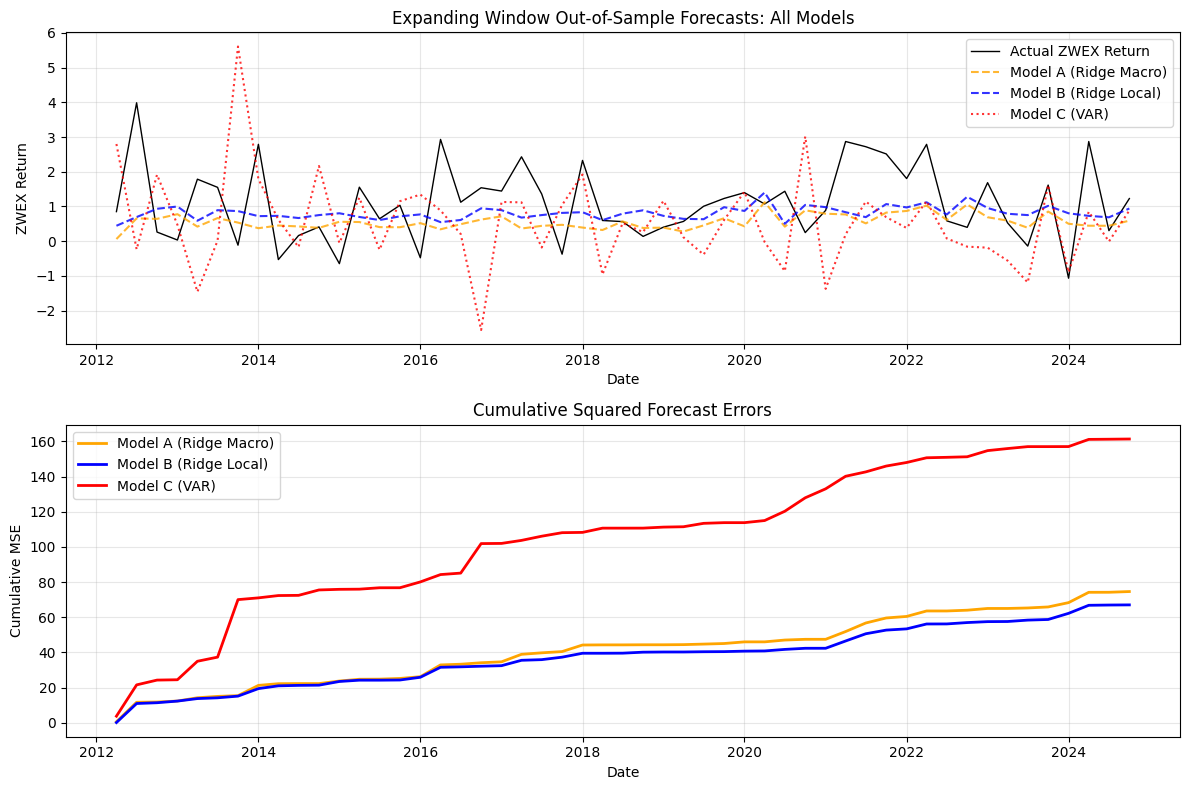

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Forecasts vs Actual
ax1 = axes[0]
ax1.plot(
    ridge_a["index"],
    ridge_a["actuals"],
    label="Actual ZWEX Return",
    color="black",
    linewidth=1,
)
ax1.plot(
    ridge_a["index"],
    ridge_a["predictions"],
    label="Model A (Ridge Macro)",
    linestyle="--",
    color="orange",
    alpha=0.8,
)
ax1.plot(
    ridge_b["index"],
    ridge_b["predictions"],
    label="Model B (Ridge Local)",
    linestyle="--",
    color="blue",
    alpha=0.8,
)
ax1.plot(
    var["index"],
    var["predictions"],
    label="Model C (VAR)",
    linestyle=":",
    color="red",
    alpha=0.8,
)
ax1.set_title("Expanding Window Out-of-Sample Forecasts: All Models")
ax1.set_xlabel("Date")
ax1.set_ylabel("ZWEX Return")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Squared Forecast Errors
ax2 = axes[1]
cum_se_a = np.cumsum((ridge_a["actuals"] - ridge_a["predictions"]) ** 2)
cum_se_b = np.cumsum((ridge_b["actuals"] - ridge_b["predictions"]) ** 2)
cum_se_var = np.cumsum((var["actuals"] - var["predictions"]) ** 2)

ax2.plot(
    ridge_a["index"],
    cum_se_a,
    label="Model A (Ridge Macro)",
    color="orange",
    linewidth=2,
)
ax2.plot(
    ridge_b["index"], cum_se_b, label="Model B (Ridge Local)", color="blue", linewidth=2
)
ax2.plot(var["index"], cum_se_var, label="Model C (VAR)", color="red", linewidth=2)
ax2.set_title("Cumulative Squared Forecast Errors")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative MSE")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()